# Set Variables

In [4]:
# -------- dataset
software_name = "camel"
# software_name = "cloudstack"
# software_name = "geode"
# software_name = "hbase"

# -------- bad smell
# bad_smell = "CC" # Cyclomatic Complexity
bad_smell = "DE" # Design
# bad_smell = "NC" # Npath Complexity

# --------
my_keyword_Based = True
my_docMaxLen = 100 if my_keyword_Based else None

# Google Colab

In [5]:
sub_folder = software_name + "_" + bad_smell

In [6]:
if software_name == "camel":
    dataset_file_name = "camel_DE - v.02"
    
elif software_name == "cloudstack":
    dataset_file_name = "cloudstack_DE - v.01"
    
elif software_name == "geode":
    dataset_file_name = "geode_DE - v.01"
    
else:
    dataset_file_name = "hbase_DE - v.01"

In [7]:
tempPre = "E:/darsy/00/02- arshad/10- paper code/"

In [8]:
tempData =   "00- My Data/Datasets/Direct Method/"
tempOutput = "01- Jupyter Notebook/Direct Method/00. Output/"

pre_path_data   = tempPre + tempData   + software_name + "/" + sub_folder + "/"
pre_path_output = tempPre + tempOutput + software_name + "/" + sub_folder + "/" + dataset_file_name + "/"

# Libs

In [26]:
import string
import re
import json
import os.path
import copy
import math
import time
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.text import TextCollection

In [10]:
# import nltk
# nltk.download("stopwords")

In [11]:
!python -V
import matplotlib
print(matplotlib.__version__)

Python 3.7.11
3.5.0


# Config

In [30]:
mypaths = {
    "dataset":        pre_path_data   + dataset_file_name + ".csv",
    "w2v": {
        # "pre_trained_model":  pre_path_data   + "w2vGoogle.bin",
        "pre_trained_model":  tempPre + tempData + "w2vGoogle.bin",
        "output_performance": pre_path_output + "performances/w2v-performance-v{}{}.json".format(output_version, "{}"),
        "output_model":       pre_path_output + "models/w2v-model-v{}{}.pth".format(output_version, "{}")
    }, 
    "tfidf": {
        "output_vec":         pre_path_output + "tfidf-vector-v01.json",
        "output_performance": pre_path_output + "performances/tfidf-performance-v{}{}.json".format(output_version, "{}"),
        "output_model":       pre_path_output + "models/tfidf-model-v{}{}.pth".format(output_version, "{}")
    },
}

preprocessing_params = {
    "columns_name":   ["text", "bug_class_2"],
    "columns_dtype" : {0: "str", 1: "int64"},
    "bug_classes": [0, 1], 
    "num_bug_classes": 2,
    "keyword_Based": my_keyword_Based,
    "docMaxLen": my_docMaxLen,
}

NameError: name 'output_version' is not defined

# I. Compose

In [13]:
class Rows(object):
    def __init__(self, columns_name, bug_classes):
        self.columns_name = columns_name
        self.bug_classes = bug_classes
    
    
    def __call__(self, df):
        # 1. Set cells to None that have just white spaces
        df = df.apply(self.white_spaces_to_None_, axis=1)
        
        # 2. Delete rows that have NaN values in each of its columns
        df.dropna(axis=0, how="any", subset=self.columns_name, inplace=True)
        
        # 3. Delete rows with class value other than [0, 1]
        indexNames = df[~df["bug_class_2"].isin(self.bug_classes)].index
        df.drop(indexNames, axis=0, inplace=True)
        
        return df
    
    
    # set columns that just have white spaces to None
    def white_spaces_to_None_(self, row):
        for i in self.columns_name:
            if row[i] and len(str(row[i]).strip()) == 0:
                row[i] = None
        return row

# II. Read Files

In [14]:
df_main = pd.read_csv(
    mypaths["dataset"], 
    names=preprocessing_params["columns_name"], 
    dtype=preprocessing_params["columns_dtype"],
    header=None, 
    skip_blank_lines=True
)

composed_pre = transforms.Compose([
    Rows(
        preprocessing_params["columns_name"], 
        preprocessing_params["bug_classes"]
    )
])

df_main = composed_pre(df_main)

In [15]:
print(len(df_main))

9019


# III. ClassDistribution
In order to see whether dataset is `imbalance` or not.

In [16]:
class ClassDistribution():
    def __init__(self, class_distributions):
        self.num_samples = sum(class_distributions.values())
        self.class_distributions = class_distributions # {"class0": num0, "class1": num1, ...}
        self.ratios = {} # {"1/0": ratio1, "1/2": ratio2, ...}
        self.percentage = {} # {"class0": perc0, "class1": perc1, ...}
    
    
    def calc_ratios(self):
        mydata_sorted = [(key, value) for key, value in sorted(self.class_distributions.items(), 
                                                               key=lambda item: item[1], reverse=True)]
        num_classes = len(self.class_distributions)
        for i in range(num_classes - 1):
            for j in range(i + 1, num_classes):
                tempKey1 = mydata_sorted[i][0]
                tempKey2 = mydata_sorted[j][0]
                mykey = tempKey1 + "/" + tempKey2
                
                tempValue1 = mydata_sorted[i][1]
                tempValue2 = mydata_sorted[j][1]
                self.ratios[mykey] = tempValue1 / tempValue2
    
    def calc_percentage(self):
        for key, value in self.class_distributions.items():
            tempPerc = (value * 100) / self.num_samples
            tempPerc = round(tempPerc)
            tempPerc = str(tempPerc) + "%"
            self.percentage[key] = tempPerc
    
    
    def plot_data(self, dataName):
        myclasses = list(self.class_distributions.keys())
        num_bugreports_perclass = list(self.class_distributions.values())

        fig, ax = plt.subplots(1, figsize=(5, 3))
        
        ax.bar(myclasses, num_bugreports_perclass, color ="maroon", label="Bug Reports", width=0.4)
        ax.set_xlabel("classes")
        ax.set_ylabel("Number of bug reports")
        ax.legend()
        ax.set_title("Number of bug reports PER classes [{}]".format(dataName))

        fig.tight_layout()

## obj

ratios     :  {'0/1': 1.8577313054499367}
percentages:  {'0': '65%', '1': '35%'}


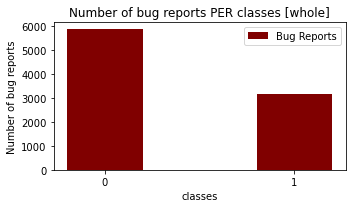

In [17]:
cds = {} # {"train": {"class0": num0, "class1": num1, ...}, "validation": {...}, ...}
# calculate class distribution for whole dataset
temp = df_main.groupby("bug_class_2").size()
cd_whole = temp.to_dict()
cd_whole = {str(key): value for key, value in cd_whole.items()}
cds["whole"] = cd_whole

# plot class distribution for whole dataset
wholeCD = ClassDistribution(cd_whole)
wholeCD.calc_ratios()
print("ratios     : ", wholeCD.ratios)
wholeCD.calc_percentage()
print("percentages: ", wholeCD.percentage)
wholeCD.plot_data("whole")